In [1]:
%load_ext autoreload
%autoreload 2
%load_ext autotime
%matplotlib inline

# AutoEncoders 101 

Some notes that I put together on AutoEncoders in my attempts to better understand them followed by a PyTorch implementation. 

AutoEncoders typically have a hidden layer $h$ that represents the input vector $\textbf{x}$. Autoencoders consist of two parts, an encoder that models $h = f(x)$ and a decoder that produces a reconstruction $r = g(h)$. AutoEncoders are trained in the hope that $h$ will take on a useful representation of the training data and are therefore usually restricted in some way to prevent the decoder from learning to perfectly reconstruct the input. 

AutoEncoders are trained to minimize a loss objective such as

$$
L(x, g(f(x)))
$$

Where L is a loss function such as cross entropy loss. 

## Denoising AutoEncoders (DAEs)

Denoising AutoEncoders are very similar to AutoEncoders with a slight variation to the loss function: 

$$
L(x, g(f(\tilde{x})))
$$

where $\tilde{x}$ is a copy of $\textbf{x}$ that has undergone some sort of perturbation to corrupt the copy. This introduces noise to the training data and helps to prevent the autoencoder from learning the identity function.  

## Variational AutoEncoders

Variational AutoEncoders (VAEs) were introduced by Diederik Kingma and Max Welling in 2013. 

Key innovation is that they can be trained to maximize the variational lower bound $L(q)$ w.r.t x by assuming that the hidden $z$ has a Gaussian distribution:

$$
\mathrm{L}(q) = \mathbb{E}_{z \sim q(z | x)}log_{p_model}(z|x) + H(q(z|x)) \\
= \mathbb{E}_{z \sim q(z | x)}logp_{model}(z|x) - D_{KL}(q(z|x)||p_{model}(z)) 
$$

The first term is the reconstruction loss found in other autoencoders while the second term tries to make the approximate posterior distribution $q(z | x)$ and the model prior $p_{model}(z)$ approach each other. 

By choosing $\mathbf{q}$ to be gaussian and noise added to the predicted mean this encourages the VAE to place high probability mass on many Z values rather than focusing on the most likely point. This assumption is important because it allows for the use of the reparameterization trick described below and removes the need for computational expensive MCMC sampling. 

Benefits: 

* Can represent much more complex relationships than traditional dimensionality reduction e.g., PCA
* No need for MCMC
* q is user defined (typically Gaussian)

### Variational Inference

Variational Inference is a technique for graphical models (such as below) to compute the posterior $p(z|x)$ which can also be written as:

$$
p(z|x) = \frac{p(x|z)p(z)}{p(x)}
$$

However, $p(x)$ is a marginal distribution and is often intractable especially in cases where z is high-dimensional. This is because $p(x) = \int p(x|z)p(z)\delta x$

There are two main approaches to solving this, the first is Monte Carlo sampling and the second is variational inference. 

<img src="./www/graphical_model.png" alt="Graphical Model" style="width: 200px;"/>

Variational inference approximates $p(z|x)$ with $q(z)$. By minimizing the KL-divergence term $KL(q || p)$ q will begin to approximate the true p. 

### The reparameterization trick 

Googling "vae reparameterization" trick returns a lot explanations such as "it allows you to backprop through a random node". In my opinion, this is a gross understatement of what is actually happening. 

The reparameterization trick allows the second term in the loss function to be computed analytically by assuming the posterior has a Gaussian distribution with added noise. Reparameterizing $z$ as:

$$
z = \mathbf{\epsilon}\mathbf{\sigma_x} + \mu_x
$$

where x is a single sample or input. $\mu$ and $\sigma$ are calculated from the model $p_{model}(x)$ hidden state $z$. 

<img src="./www/reparam_trick.png" alt="Reparameterization Trick" width="400"/>


## Adversarial AutoEncoders

Adversarial Autoencoders (AAEs) are an extension/combination of VAEs and Generative Adversarial Networks. They can be trained in a similar manner to VAEs. The image below (Figure 1 from the paper) shows the standard setup for an AAE. 

There are some interesting extensions of this diagram for supervised and semi-supervised tasks that essentially consist of adding another discriminator network on top that learns the categorical label distribution.

<img src="./www/aae.png" alt="Adversarial AutoEncoder" style="width: 500px; height: 250px;"/>

### A quick note on GANs

GANs establish a min-max adversarial game between two neural networks, a generative model G and a discriminative model D. The discriminator computes the probability that a point $\textbf(x)$ in the data space is from the data distribution that we want to model rather than from the generative model (negative samples). 

The generator _G_ and discriminator _D_ are trained in two stages: 1 - train _D_ to distinguish true samples from the fake samples. 2 - Train _G_ to fool _D_ with it's generated samples.

### Training AAEs

The adversarial network and autoencoder are trained jointly in two phases the reconstruction phase and the regulariziation phase. In the reconstruction phase the autoencoder attempts to minimize the reconstruction loss. In the regularization phase, the adversarial network first updates _D_ to identify true samples from the generated samples, then it updates it's generator (which is also the encoder of the autoencoder) to confuse the discriminative network. 

There are a number of choices for the encoder, $q(\mathbf{z}|\mathbf{x})$ of adversarial autoencoders: 

1. Deterministic: $q(\mathbf{z}|\mathbf{x})$ is a deterministic function of $\mathbf{x}$ similar to a regular autoencoder
2. Gaussian posterior: Essentially a VAE 
3. Universal Approximator Posterior: This seems the most complicated and I didn't pay much attention to it. 

The authors of the paper note that all 3 approaches yield similar results in their tests and so they only report the deterministic results. 

# Torch Implementation

That's enough theory, below is an implementation of DAE, VAE and AAE using the MNIST dataset. 


In [2]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import numpy as np
from scipy.stats import norm


time: 767 ms


## Initialize the DataLoaders

Fortunately the MNIST dataset is included with torchvision so iterators can be easily constructed. 

In [3]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=16, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, 
                   transform=transforms.ToTensor()),
    batch_size=16, shuffle=True)


time: 40.1 ms


### Transform to add Gaussian Noise

Found this [here](https://discuss.pytorch.org/t/how-to-add-noise-to-mnist-dataset-when-using-pytorch/59745)

In [4]:
class AddGaussianNoise:
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + f'(mean={self.mean}, std={self.std})'

time: 1.42 ms


## Define the AutoEncoders

We'll just use feedforward layers for the encoder and decoder to keep things simple. 

In [5]:
class DenoisingAutoEncoder(nn.Module):
    """Denoising AutoEncoder."""
    def __init__(self, img_size, encoder_dim, z_dim, noise_machine=None):
        """Initialization."""
        super(DenoisingAutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(img_size, encoder_dim),
            nn.ReLU(),
            nn.Linear(encoder_dim, z_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, encoder_dim),
            nn.ReLU(),
            nn.Linear(encoder_dim, img_size)
        )
        
        self.noise_machine = noise_machine
        
    def encode(self, x):
        x = x.view(-1, 784)
        if self.noise_machine:
            x = self.noise_machine(x)
        return self.encoder(x)
    
    def decode(self, z):
        return torch.sigmoid(self.decoder(z))
        
    def forward(self, x):
        z = self.encode(x)
        return self.decode(z), z, _, _
    
    def __repr__(self):
        return self.__class__.__name__
        
    @staticmethod
    def loss_function(recon_x, x, mu, logvar, z):
        return F.binary_cross_entropy(recon_x, x.view(-1, 784), 
                                      reduction='sum')

class VAE(nn.Module):
    """Base AutoEncoder."""
    def __init__(self, img_size, encoder_dim, z_dim):
        """Initialization."""
        super(VAE, self).__init__()
        self.encoder = nn.Linear(img_size, encoder_dim)
        self.h2mu = nn.Linear(encoder_dim, z_dim)
        self.h2logvar = nn.Linear(encoder_dim, z_dim)
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, encoder_dim),
            nn.ReLU(),
            nn.Linear(encoder_dim, img_size)
        )
        
    def encode(self, x):
        h1 = F.relu(self.encoder(x))
        return self.h2mu(h1), self.h2logvar(h1)
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    
    def decode(self, z):
        return torch.sigmoid(self.decoder(z))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), z, mu, logvar
    
    def __repr__(self):
        return self.__class__.__name__
    
    @staticmethod
    def loss_function(recon_x, x, mu, logvar, z):
        BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), 
                                     reduction='sum')
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        return BCE + KLD
    
class AdversarialAutoEncoder(nn.Module):
    """Adversarial AutoEncoder."""
    def __init__(self, img_size, encoder_dim, z_dim, d_dim, 
                 noise_machine=None):
        """Initialization."""
        super(AdversarialAutoEncoder, self).__init__()
        self.encoder = nn.Linear(img_size, encoder_dim)
        self.h2mu = nn.Linear(encoder_dim, z_dim)
        self.h2logvar = nn.Linear(encoder_dim, z_dim)
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, encoder_dim),
            nn.ReLU(),
            nn.Linear(encoder_dim, img_size)
        )
        self.discriminator = nn.Sequential(
            nn.Linear(z_dim, d_dim), 
            nn.ReLU(),
            nn.Linear(d_dim, 1), 
            nn.Sigmoid()
        )
        self.noise_machine = noise_machine
        
    def encode(self, x):
        h1 = F.relu(self.encoder(x))
        return self.h2mu(h1), self.h2logvar(h1)
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    
    def decode(self, z):
        return torch.sigmoid(self.decoder(z))

    def forward(self, x):
        if self.noise_machine:
            x = self.noise_machine(x)
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), z, mu, logvar
    
    def __repr__(self):
        if self.noise_machine:
            return "Denoising" + self.__class__.__name__
        else:
            return self.__class__.__name__
    
    def loss_adv(self, z):
        zn = torch.randn_like(z)
        zeros = torch.zeros(len(z), 1, device=z.device)
        ones = torch.ones(len(z), 1, device=z.device)
        loss_d = F.binary_cross_entropy(
            self.discriminator(z.detach()), zeros) + \
            F.binary_cross_entropy(self.discriminator(zn), ones)
        loss_g = F.binary_cross_entropy(self.discriminator(z), ones)
        return loss_d, loss_g
    
    def loss_function(self, recon_x, x, mu, logvar, z):
        loss_d, adv = self.loss_adv(z)
        losses = {'rec': F.binary_cross_entropy(recon_x, x.view(-1, 784), 
                                                reduction='sum'),
                  'adv': adv,
                  '|lvar|': logvar.abs().sum(dim=1).mean(),
                  'loss_d': loss_d}
        losses['loss'] = losses['rec'] + losses['adv'] + losses['|lvar|']
        return losses

time: 40.7 ms


## Create the training/testing routines

Create a simple training class to handle the training and testing of the various autoencoders.

In [6]:
class AutoEncoderTrainer:
    """AutoEncoder Training class."""
    def __init__(self, model, optimizer, train_loader, test_loader): 
        """Initialization."""
        self.model = model
        self.device = torch.device("cuda" if torch.cuda.is_available() else
                                   "cpu")
        self.optimizer = optimizer(self.model.parameters(), lr=1e-3)
        self.train_loader = train_loader
        self.test_loader = test_loader
        
    def train_iter(self):
        """Single pass through the training data."""
        self.model.train()
        train_loss = 0
        for batch_idx, (data, _) in enumerate(self.train_loader):
            data = data.to(self.device)
            self.optimizer.zero_grad()
            logits, z, mu, logvar = self.model(data)
            loss = self.model.loss_function(logits, data, mu, logvar, z)
            if isinstance(self.model, AdversarialAutoEncoder):
                loss['loss'].backward()
                loss['loss_d'].backward()
                loss = loss['loss']
            else:
                loss.backward()
            train_loss += loss.item()
            self.optimizer.step()
        
        return train_loss / len(self.train_loader.dataset)
    
    def test_iter(self):
        """Single pass through the test set."""
        self.model.eval()
        test_loss = 0
        with torch.no_grad():
            for i, (data, _) in enumerate(self.test_loader):
                data = data.to(self.device)
                logits, z, mu, logvar = self.model(data)
                if isinstance(self.model, AdversarialAutoEncoder):
                    test_loss += self.model.loss_function(
                        logits, data, mu, logvar, z)['loss'].item()
                else:
                    test_loss += self.model.loss_function(
                        logits, data, mu, logvar, z).item()

        return test_loss / len(self.test_loader.dataset)
    
    def train_and_evaluate(self, epochs):
        """Run training and evaluation."""
        self.model.to(self.device)
        test_losses = []
        print(f"Training: {self.model.__repr__()}")
        for epoch in range(epochs):
            train_loss = self.train_iter()
            test_losses.append(self.test_iter())
            
            print(f"\tEpoch: {epoch}, Train Loss: {train_loss:.4f}," 
                  f"Test Loss: {test_losses[-1]:.4f}")

time: 4.59 ms


## Train the Models 

Create the models and trainers and run training.

In [7]:
vae = VAE(784, 400, 2                              )
dae = DenoisingAutoEncoder(784, 400, 2, AddGaussianNoise())
aae = AdversarialAutoEncoder(784, 400, 2, 30)
daae = AdversarialAutoEncoder(784, 400, 2, 30, AddGaussianNoise())
vae_trainer = AutoEncoderTrainer(vae, optim.Adam, train_loader, test_loader)
dae_trainer = AutoEncoderTrainer(dae, optim.Adam, train_loader, test_loader)
aae_trainer = AutoEncoderTrainer(aae, optim.Adam, train_loader, test_loader)
daae_trainer = AutoEncoderTrainer(daae, optim.Adam, train_loader, test_loader)

time: 23.2 ms


In [8]:
dae_trainer.train_and_evaluate(10)
vae_trainer.train_and_evaluate(10)
aae_trainer.train_and_evaluate(10)
daae_trainer.train_and_evaluate(10)

Training: DenoisingAutoEncoder
	Epoch: 0, Train Loss: 177.7484, Test Loss: 170.5738
	Epoch: 1, Train Loss: 169.8040, Test Loss: 167.3298
	Epoch: 2, Train Loss: 167.5998, Test Loss: 166.1104
	Epoch: 3, Train Loss: 166.2784, Test Loss: 164.7347
	Epoch: 4, Train Loss: 165.3784, Test Loss: 164.0765
	Epoch: 5, Train Loss: 164.6562, Test Loss: 163.8394
	Epoch: 6, Train Loss: 164.3082, Test Loss: 163.2384
	Epoch: 7, Train Loss: 163.8920, Test Loss: 163.0829
	Epoch: 8, Train Loss: 163.5997, Test Loss: 162.3888
	Epoch: 9, Train Loss: 163.4914, Test Loss: 162.4421
Training: VAE
	Epoch: 0, Train Loss: 170.9826, Test Loss: 162.3123
	Epoch: 1, Train Loss: 159.9996, Test Loss: 157.9523
	Epoch: 2, Train Loss: 156.6306, Test Loss: 155.6000
	Epoch: 3, Train Loss: 154.6988, Test Loss: 154.5158
	Epoch: 4, Train Loss: 153.4677, Test Loss: 153.1228
	Epoch: 5, Train Loss: 152.5002, Test Loss: 152.5380
	Epoch: 6, Train Loss: 151.7853, Test Loss: 152.0900
	Epoch: 7, Train Loss: 151.1515, Test Loss: 152.0328
	

It's interesting but unsurprising that the loss of both denoising models is worse. It's hard to evaluate the benefits of adding noise in this toy case, the manifolds plotted below don't appear to be any smoother.

Also by locking the hidden dimension (z) to 2 we degrade performance so that we can generate the manifolds below. 

More complex Encoders/Decoders and a higher dimension for z should yield much better results.

## Plot the manifold

Found this code online somehwere (Kaggle I think.). If we set the hidden dimension (z) to be 2 we can construct a 2D Gaussian manifold to show how the hidden layer represents the various digits in the MNIST dataset. 

Below I've plotted the manifold for each model. 

In [10]:
def plot_manifold(model, n=20, digit_size=28):
    figure = np.zeros((digit_size * n, digit_size * n))

    # Construct grid of latent variable values
    grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
    grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

    # decode for each square in the grid
    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z_sample = np.array([[xi, yi]])
            z_sample = torch.from_numpy(
                np.tile(z_sample, 16).reshape(16, 2).astype(np.float32))
            x_decoded = model.decode(z_sample).detach().numpy()
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    plt.imshow(figure, cmap='gnuplot2')
    plt.show()  

time: 2.13 ms


### Denoising AutoEncoder Manifold


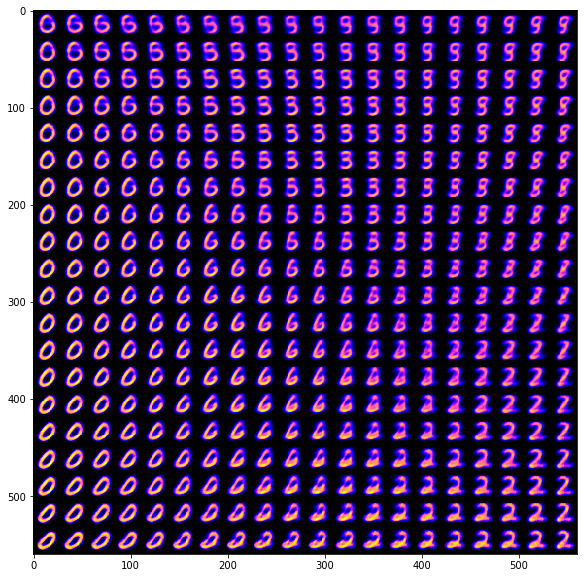

time: 333 ms


In [11]:
plot_manifold(dae_trainer.model)

### Variational AutoEncoder Manifold

# Resources/References

[1 - AutoEncoding Variational Bayes](https://arxiv.org/abs/1312.6114)

[2 - Deep Learning Chapter 14, Goodfellow](https://www.deeplearningbook.org/contents/autoencoders.html)

[3 - Adversarial AutoEncoders](https://arxiv.org/abs/1511.05644)

[4 - An Introduction to Variational AutoEncoders](https://arxiv.org/pdf/1906.02691.pdf)

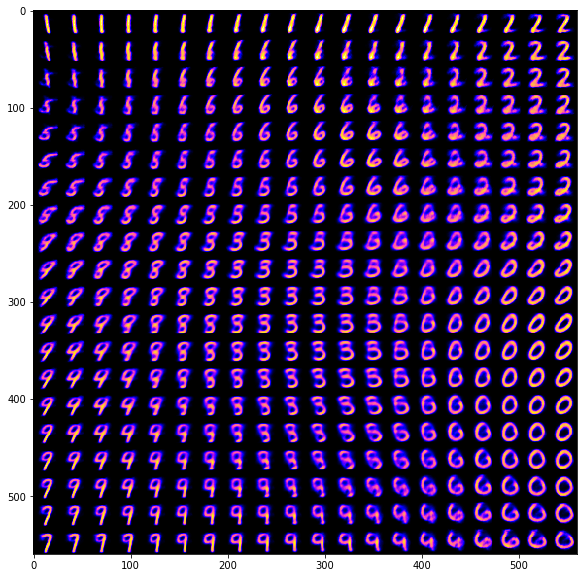

time: 294 ms


In [12]:
plot_manifold(vae_trainer.model)

### Adversarial AutoEncoder Manifold

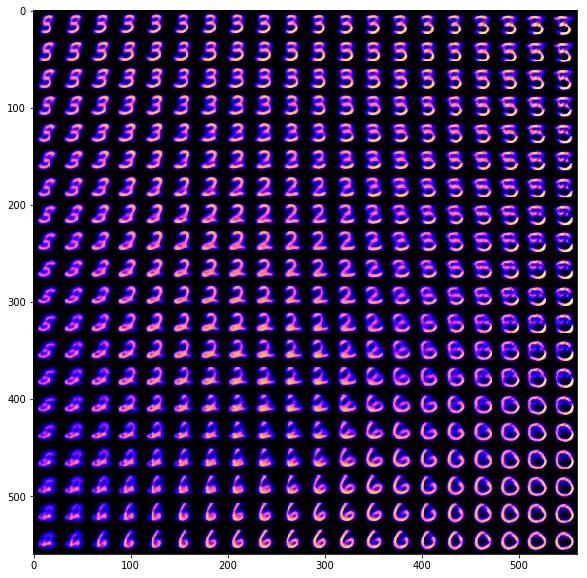

time: 319 ms


In [14]:
plot_manifold(aae_trainer.model)

### Denoising Adversarial AutoEncoder Manifold

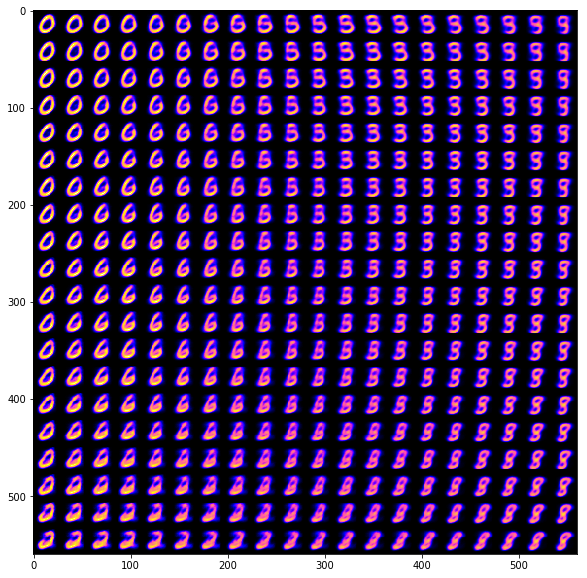

time: 338 ms


In [16]:
plot_manifold(daae_trainer.model)

# Resources/References

[1 - AutoEncoding Variational Bayes](https://arxiv.org/abs/1312.6114)

[2 - Deep Learning Chapter 14, Goodfellow](https://www.deeplearningbook.org/contents/autoencoders.html)

[3 - Adversarial AutoEncoders](https://arxiv.org/abs/1511.05644)

[4 - Educating Text AutoEncoders](https://arxiv.org/pdf/1905.12777.pdf)

[5 - An Introduction to Variational AutoEncoders](https://arxiv.org/pdf/1906.02691.pdf)

[6 - Ali Ghodsi Lecture: Variational AutoEncoders](https://www.youtube.com/watch?v=uaaqyVS9-rM)

[7 - A.I. Socratic Circles: VAE Lecture](https://www.youtube.com/watch?v=Tc-XfiDPLf4)

[8 - Reparameterization Blog Post](https://gregorygundersen.com/blog/2018/04/29/reparameterization/)

[9 - VAE Example](https://github.com/pytorch/examples/blob/master/vae/main.py)